In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score
from src.model_selection import test_model
from sklearn.metrics import confusion_matrix, mean_squared_error
from scipy.stats import pearsonr

In [2]:
col_names = pd.read_csv("communities_names.csv", header = None)
list_of_column_names = []

for index, row_data in col_names.iterrows():
    list_of_column_names.append(str(row_data[0]))

df = pd.read_csv("communities_data.csv", names = list_of_column_names)

In [3]:
target = "ViolentCrimesPerPop"

In [4]:
display(df.head())
df.head()[target]

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


0    0.20
1    0.67
2    0.43
3    0.12
4    0.03
Name: ViolentCrimesPerPop, dtype: float64

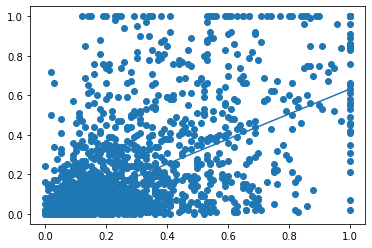

In [5]:
plt.scatter(df[target], df["racepctblack"])
c, p = pearsonr(df[target], df["racepctblack"])
plt.plot([0,c])

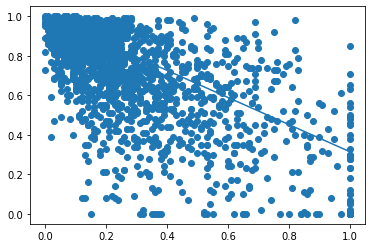

In [6]:
plt.scatter(df[target], df["racePctWhite"])
c, p = pearsonr(df[target], df["racePctWhite"])
plt.plot([1,1+c])

In [7]:
from src.processing import import_data
from src.model_selection import test_model

In [8]:
data_init, data_full, data, data_protected, data_y = import_data()

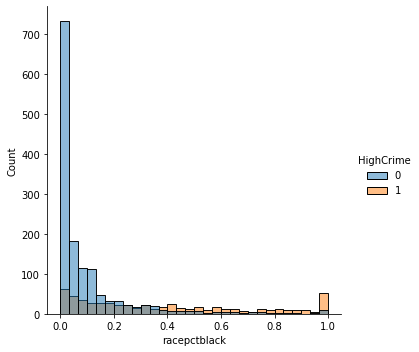

In [9]:
sns.displot(data=data_full, x="racepctblack", hue="HighCrime")

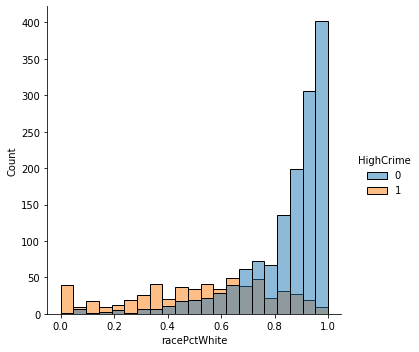

In [10]:
sns.displot(data=data_full, x="racePctWhite", hue="HighCrime")

# Testing test model with Logistig regression on high crimerate

In [11]:
def scaling_func(scaling_obj):
    def scale(x_train, x_test):
        scaler = scaling_obj().fit(x_train)
        return scaler.transform(x_train), scaler.transform(x_test)
    return scale

In [12]:
X, y = data, data_y["HighCrime"]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scaler = scaling_func(preprocessing.StandardScaler)

model = LogisticRegression
model_params = {"random_state":1, "max_iter":500}

preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

# Evaluation system
## How to calculate equalized odds

Recall and precision deffs https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124

The two elements of equalized odds

$tp / (tp+fn)$ # recall

$fp/(tn+fp)$ # false positive ratio


``` python

def calc_recall(tp,fn):
    """
    True positive rate (TPR, also called sensitivity) 
    """
    return tp/(tp+fn)
def calc_fpr(tn,fp):
    """
    False positive rate (also known as fall-out or false alarm ratio) 
    """
    return fp/(tn+fp)

def equalized_odds(y_true, y_pred):
    tn, fp, fn, tp  = confusion_matrix(y_true, y_pred).ravel()
    recall = calc_recall(tp,fn)
    fpr = calc_fpr(tn,fp)
    return recall, fpr

```

In [13]:
from src.metrics import equalized_odds

In [14]:
IsBlack = data_full.IsBlack == 1

In [15]:
IsWhite = data_full.racePctWhite >= 0.75

### Equalized odds regarding black ratio

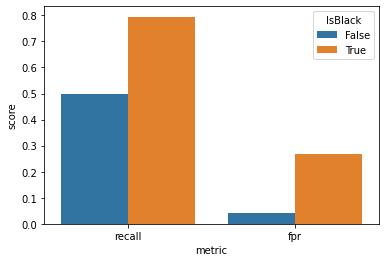

In [16]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [17]:
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [18]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1411
           1       0.79      0.70      0.74       583

    accuracy                           0.86      1994
   macro avg       0.83      0.81      0.82      1994
weighted avg       0.85      0.86      0.85      1994



In [19]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.7717908082408875

In [20]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8958180484225972

In [21]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 377.0)

In [22]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 142.0)

# Debias data

In [23]:
from src.debias_data import debias_data

In [24]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [25]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [26]:
# Initialize the scaling and debiasing function
l_value = 0.05
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

model = LogisticRegression
model_params = {"random_state":1, "max_iter":500}

preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

### Equalized odds regarding black ratio with unbias data

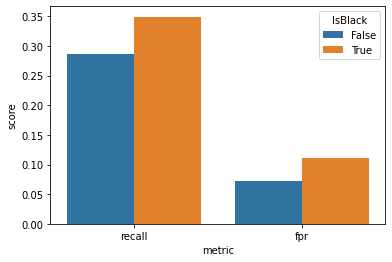

In [28]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df_reproject = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df_reproject, x="metric", y="score", hue="IsBlack")
plt.show()

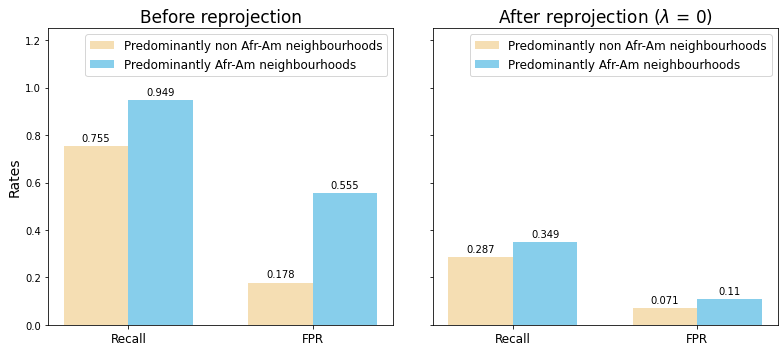

In [49]:
# Plot equalized odds for black vs non-black neighbourhoods

white_neig_eq_odds_before = np.round(tmp_df[tmp_df.IsBlack == 0].score.values,3)
black_neig_eq_odds_before = np.round(tmp_df[tmp_df.IsBlack == 1].score.values,3)

white_neig_eq_odds_after = np.round(tmp_df_reproject[tmp_df_reproject.IsBlack == 0].score.values,3)
black_neig_eq_odds_after = np.round(tmp_df_reproject[tmp_df_reproject.IsBlack == 1].score.values,3)


cols_for_hist = ["Recall", "FPR"]
x = np.arange(len(cols_for_hist))  # the label locations
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), sharey = True)
rects1 = ax1.bar(x - width/2, white_neig_eq_odds_before, width, label='Predominantly non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax1.bar(x + width/2, black_neig_eq_odds_before, width, label='Predominantly Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Rates', fontsize = 14)
ax1.set_title('Before reprojection', fontsize = 17)
ax1.set_xticks(x)
ax1.set_xticklabels(cols_for_hist, fontsize = 12)
ax1.set_ylim(top = 0.5)
ax1.legend(fontsize = 12)

autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Plot equalized odds for black vs non-black neighbourhoods

rects1 = ax2.bar(x - width/2, white_neig_eq_odds_after, width, label='Predominantly non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax2.bar(x + width/2, black_neig_eq_odds_after, width, label='Predominantly Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title(f'After reprojection ($\lambda$ = 0)', fontsize = 17)
ax2.set_xticks(x)
ax2.set_xticklabels(cols_for_hist, fontsize = 12)
ax2.set_ylim(top = 1.25)
ax2.legend(fontsize = 12)

autolabel(rects1, ax2)
autolabel(rects2, ax2)

fig.tight_layout()

plt.savefig("Plots/eq_odds_before_after_reproject_logreg.png")


plt.show()

In [30]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1411
           1       0.64      0.33      0.43       583

    accuracy                           0.75      1994
   macro avg       0.70      0.63      0.64      1994
weighted avg       0.73      0.75      0.72      1994



In [31]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.5515055467511886

In [32]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8400586940572267

In [33]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 164.0)

In [34]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 138.0)

# Berk linear constraint model

In [35]:
from src.linear_models import BerkFairLogreg

In [36]:
def scaling_func(scaling_obj):
    def scale(x_train, x_test):
        scaler = scaling_obj().fit(x_train)
        return scaler.transform(x_train), scaler.transform(x_test)
    return scale

In [37]:
protected_col = "IsBlack"
berk_data = data.copy()
berk_data["interception"] = np.ones(len(data))
berk_data[protected_col] = data_full[protected_col]
assert berk_data.columns[-1] == protected_col, f"The last data must be the protected column, i.e. {protected_col}"

X, y = berk_data, data_y["HighCrime"].values

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scaler = scaling_func(preprocessing.StandardScaler)

model = BerkFairLogreg
model_params = {"lambda_":1, "gamma_":0.001}

preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   1.89295686E+00


The model end state is 1 which is good


tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599450E-01   1.89295686E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   1.82385362E+00
tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599450E-01   1.82385362E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)


The model end state is 1 which is good


  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   1.87924722E+00
tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599450E-01   1.87924722E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)


The model end state is 1 which is good


  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   1.83506708E+00
tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599450E-01   1.83506708E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)


The model end state is 1 which is good


  NIT   NF   F                       GTG
    0    1  6.931471805599448E-01   1.73851005E+00


The model end state is 1 which is good


tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599448E-01   1.73851005E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [38]:
yhat = preds
preds = np.array([1 if x > 0 else 0 for x in preds])

In [39]:
preds.mean()

0.42978936810431295

### Equalized odds regarding black ratio with unbias data

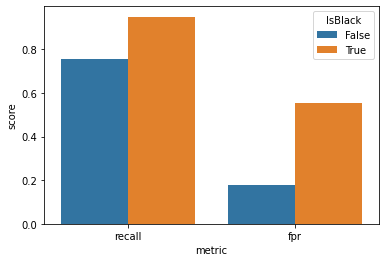

In [40]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [41]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1411
           1       0.60      0.89      0.72       583

    accuracy                           0.80      1994
   macro avg       0.77      0.82      0.78      1994
weighted avg       0.84      0.80      0.80      1994



In [42]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.7606973058637084

In [43]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8129126925898753

In [44]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 506)

In [45]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 351)